# Coronavirus Erickson

On April 22, Drs. Erickson and Massihi from Kern County California gave a press briefing where they detailed the testing statistics from their healthcare facilities and made some observations as to what they thought the fatality rate of coronavirus was. And they suggested lifting the lockdown. Their heterodox fatality estimates and policy recommendations were widely panned by the media and scientists. Their press briefing was censored from Youtube and Facebook for disagreeing with local authorities.

The banned video (and the story behind its removal) is available here: https://www.turnto23.com/news/coronavirus/video-interview-with-dr-dan-erickson-and-dr-artin-massihi-taken-down-from-youtube

The video asks an important question? How deadly is coronavirus? Two measures of its deadliness are the Case Fatality Rate and the Infection Fatality Rate. Case fatality rate is the rate at which people who test positive die. The infection fatality rate is the rate at which people infected with coronavirus die. 

These are very different because we don't test everyone and so cannot see exactly how many people have been infected. We know that many or most coronavirus infections are mild or asymptomatic and that these infections are rarely tested. Initial testing focused on diagnosing people who were seriously ill and coming into the healthcare system for treatment. As time passes, testing is broadening to include testing vulnerable and at risk populations more widely, including testing entire long-term care facilities or prisons, or healthcare facility staff, or frontline workers like police officers.

During the month of February the Diamond Princess cruise ship was languishing in port in Japan, having a widespread outbreak of coronavirus. Everyone on the ship was tested. This is some of the earliest data that provided an estimate of the Infection Fatality Rate. On March 26th, Nature published the Infecton Fatality Rate estimate of 0.5% (https://www.nature.com/articles/d41586-020-00885-w):

> The group also estimates that the infection fatality rate (IFR) in China — the proportion of all infections, including asymptomatic ones, that result in death — is even lower, at roughly 0.5%. The IFR is especially tricky to calculate in the population, because some deaths go undetected if the person didn’t show symptoms or get tested.

In late April, several antibody seroprevalence studies were done in the United States, one in Santa Clara (CA) county, one in LA county (CA), one in Miami Dade County (FL) and one in New York state.

- In Miami Dade county
  https://www.miamidade.gov/releases/2020-04-24-sample-testing-results.asp
- In Santa Clara county
- In 


In [ ]:
import datetime
from pprint import pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import pandas as pd
from pandas import to_datetime
from pathlib import Path
import plotly.express as px
from scipy.special import gamma
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
import time
import timeit

from coronavirus.data import (
    load_cdc_deaths_by_age,
    load_census_state_population_by_age_data,
    load_covidtracking_state_data, 
    load_nyc_age_comorbidity_death_data, 
    fill_before_first, before_threshold, 
    add_derived_values_cols,
    add_erickson_estimates,
)
from coronavirus.viz import plot_trajectories, days_since_trim, prioritize_entities

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
states_df = (load_covidtracking_state_data(download=False, cache=True)
             .pipe(add_derived_values_cols))
states_df.groupby('entity').last().head()


,date,cases,deaths,tests,population,cases_per_million,cases_per_day,cases_per_day_7day_avg,cases_per_day_3day_avg,cases_per_million_per_day,...,deaths_per_test,deaths_per_day_3day_avg_tests_per_day_3day_avg_ratio,deaths_per_day_7day_avg_tests_per_day_7day_avg_ratio,deaths_per_test_per_day,deaths_per_test_per_day_3day_avg,deaths_per_test_per_day_7day_avg,deaths_per_day_3day_avg_tests_per_day_3day_avg_ratio_14day_ratio,deaths_per_test_per_day_3day_avg_14day_ratio,deaths_per_day_7day_avg_tests_per_day_7day_avg_ratio_14day_ratio,deaths_per_test_per_day_7day_avg_14day_ratio
entity,,,,,,,,,,,,,,,,,,,,,
Alabama,2020-05-03,7725.0,290.0,92500.0,4903185,1575.506533,291.0,207.857143,235.333333,59.349178,...,0.003135,0.003959,0.003905,0.006873,1.386420e-02,0.010026,1.757353,3.962453e+00,1.544738,2.284093
Alaska,2020-05-03,368.0,9.0,21578.0,731545,503.044925,3.0,3.857143,4.333333,4.100910,...,0.000417,0.000000,0.000000,0.000000,1.156482e-18,0.000000,0.000000,1.797174e-15,0.000000,0.000000
Arizona,2020-05-03,8640.0,362.0,81119.0,7278717,1187.022383,276.0,302.000000,330.666667,37.918771,...,0.004463,0.004500,0.005335,0.004484,4.496781e-03,0.006712,0.740144,7.340539e-01,0.841276,0.960019
Arkansas,2020-05-03,3431.0,76.0,52890.0,3017804,1136.919429,59.0,70.000000,58.666667,19.550640,...,0.001437,0.003325,0.002012,0.002294,3.109513e-03,0.003119,1.700288,3.013351e-01,0.694371,0.510696
California,2020-05-03,53616.0,2215.0,715751.0,39512223,1356.947191,1419.0,1636.000000,1566.333333,35.912938,...,0.003095,0.002577,0.002663,0.001520,2.556444e-03,0.002697,0.266107,-7.260321e-02,0.437239,-0.682569


## Age and Fatality

How old are people dying of coronavirus?

- Less than 1% of deaths (in the USA) come from people less than 35 years old.
- Less than 2.8% of deaths come from people less than 45 years old.
- Less than 8% of deaths come from people less than 55 years old.
- Less than 20.5% of deaths come from people less than 65 years old.

New York City reports deaths and cases by age. This allows us to look at the case fatality rate by age in NYC. See below.

In [3]:
df = load_cdc_deaths_by_age(download=False, cache=True)
df

,date,entity,deaths,age_band,min_age,max_age,cumulative_deaths,cumulative_death_pct
15,04/25/2020,United States,4.0,Under 1 year,0,0,4.0,0.011587
16,04/25/2020,United States,2.0,1–4 years,1,4,6.0,0.017381
17,04/25/2020,United States,3.0,5–14 years,5,14,9.0,0.026071
18,04/25/2020,United States,39.0,15–24 years,15,24,48.0,0.139046
19,04/25/2020,United States,263.0,25–34 years,25,34,311.0,0.900901
20,04/25/2020,United States,647.0,35–44 years,35,44,958.0,2.775122
21,04/25/2020,United States,1776.0,45–54 years,45,54,2734.0,7.919817
22,04/25/2020,United States,4347.0,55–64 years,55,64,7081.0,20.512152
23,04/25/2020,United States,7419.0,65–74 years,65,74,14500.0,42.003418
24,04/25/2020,United States,9416.0,75–84 years,75,84,23916.0,69.279569


In [4]:
age_comorbidity_df, df = load_nyc_age_comorbidity_death_data(cache=True)
# display(age_comorbidity_df)
print('New York City Case Fatality Rate by Age')
df.loc[:, ['age_band', 'deaths_per_case', 'deaths', 'cases']]

New York City Case Fatality Rate by Age


,age_band,deaths_per_case,deaths,cases
0,0 to 17,0.001617,6,3711
1,18 to 44,0.008495,507,59684
2,45 to 64,0.046940,2803,59715
3,65 to 74,0.152962,3101,20273
4,75+,0.332433,6152,18506


## Comorbidity and Fatality

Comorbidity data is available for COVID-19 fatalilies from NYC and Massachusetts.

In NYC, 99.2% of deaths have a comorbidity. Source: https://www1.nyc.gov/site/doh/covid/covid-19-data.page

In Massachusetts, 98.2% of deaths have a comorbidity. Source: https://www.mass.gov/doc/covid-19-dashboard-april-30-2020/download.


In [5]:
df, _ = load_nyc_age_comorbidity_death_data(cache=True)
df = df.loc[lambda d: (d['comorbidity'] != 'unknown') & (d['age_band'] != 'unknown')]
df = df.pivot(index='age_band', columns='comorbidity', values='deaths')
df['total'] = df.sum(axis=1)
df['pct_comorbid'] = df['yes'] / df['total']
print('Percent of NYC deaths with a comorbidity:')
print(f"{(df['yes'].sum() / df['total'].sum()):.3f}\n")
print('Percent of NYC deaths with a comorbidity by age:')
df

Percent of NYC deaths with a comorbidity:
0.992

Percent of NYC deaths with a comorbidity by age:


comorbidity,no,yes,total,pct_comorbid
age_band,,,,
0 to 17,0,6,6,1.000000
18 to 44,14,401,415,0.966265
45 to 64,54,2363,2417,0.977658
65 to 74,4,2255,2259,0.998229
75+,1,4140,4141,0.999759


## Rate Trends

Tests per capita represents the amount of the total population that has been tested. It represents the scaling of testing infrastructure and the implementation of sentinel testing, contact tracing and other testing based containment measures. It represents the surging of tests in states with severe outbreaks.

Cases per test represents the sickness of the population being tested, the extent of the infection across the population, and the proportion of different sicknesses such as influenza among the population being tested.

Deaths per case represents the quality of health care, issues with over- or underusing ventilators, the population of people getting infected (such as people living in long-term care facilities), and increased recording/testing of coronavirus deaths.


n_top: 4, n_show: 200, includes: [], excludes: []


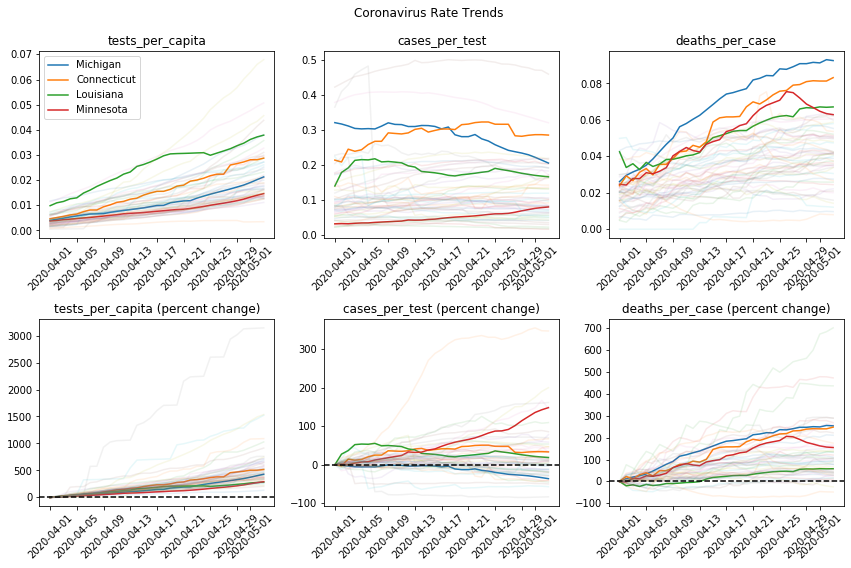

In [6]:
# days_since_col = 'date'; days_since_thresh = pd.to_datetime('2020-03-16');
days_since_col = 'date'; days_since_thresh = pd.to_datetime('2020-04-01');
df = states_df
df = df.assign(tests_per_capita=(1 * df['tests'] / df['population']))
df = df.loc[~before_threshold(df, days_since_col, days_since_thresh)]
df = df.loc[:, ['date', 'entity', 'population', 'tests_per_capita', 'cases_per_test', 'deaths_per_case']]

# states = ['Vermont', 'Michigan', 'New York', 'California', 'Georgia', 'Rhode Island', ]
# fig, axes = plt.subplots(len(states) // 3, 3, figsize=(14, 6), sharey=True)
# for i, state in enumerate(states):
#     ax = axes[i // 3, i % 3]
# #     df = df[df['entity'] == state]
#     ax.tick_params('x', labelrotation=45)
#     for col in ['tests_per_capita', 'cases_per_test', 'deaths_per_case']:
#         ax.plot(df.loc[df['entity'] == state, 'date'], 
#                 df.loc[df['entity'] == state, col], 
#                 label=col)
#         ax.set_title(state)

# plt.suptitle(f'Coronavirus Rate Trends')
# plt.legend()
# plt.tight_layout(rect=(0, 0, 1, 0.95))
# plt.show()

includes = [
#     'Vermont', 
#     'Massachusetts'
]
excludes = [
#     'Oregon', 
#     'Texas'
]
ascending = False
n_top = 4
n_show = 200
values_col = 'deaths_per_case'
index_col = 'date'
top_ents, show_ents, all_ents = prioritize_entities(
    df, index_col, values_col, ascending=ascending, 
    n_top=n_top, n_show=n_show, includes=includes, excludes=excludes)


fig, axes = plt.subplots(2, 3, figsize=(12,8))
background_alpha = 0.1
for i, col in enumerate(['tests_per_capita', 'cases_per_test', 'deaths_per_case']):
    ax = axes[0, i]
    for entity in all_ents:
        if entity in show_ents:
            alpha = 1 if entity in top_ents else background_alpha
            label = entity if entity in top_ents else None
            ax.plot(df.loc[df['entity'] == entity, 'date'], 
                    df.loc[df['entity'] == entity, col], 
                    alpha=alpha,
                    label=label)
            
    ax.set_title(col)
    ax.tick_params('x', labelrotation=45)
    if i == 0:
        ax.legend()
    
    ax = axes[1, i]
    for entity in all_ents:
        if entity in show_ents:
            alpha = 1 if entity in top_ents else background_alpha
            label = entity if entity in top_ents else None
            vals = df.loc[df['entity'] == entity, col]
            ax.plot(df.loc[df['entity'] == entity, 'date'], 
                    100 * (vals - vals.iloc[0]) / vals.iloc[0], 
                    alpha=alpha,
                    label=label)
    
    ax.axhline(y=0, color='k', linestyle='--')
    ax.set_title(f'{col} (percent change)')
    ax.tick_params('x', labelrotation=45)
#     ax.legend()

plt.suptitle(f'Coronavirus Rate Trends')
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()


# states = list(sorted(df['entity'].unique()))
# fig, axes = plt.subplots(1, 3, figsize=(12,8))
# for i, col in enumerate(['tests_per_capita', 'cases_per_test', 'deaths_per_case']):
#     ax = axes[1, i]
#     for state in states:
#         if state in show_ents:
#             alpha = 1 if state in top_ents else 0.2
#             label = state if state in top_ents else None
#             vals = df.loc[df['entity'] == state, col]
#             ax.plot(df.loc[df['entity'] == state, 'date'], 
#                     vals / vals.iloc[0], 
#                     alpha=alpha,
#                     label=label)
#     ax.set_title(col)
#     ax.tick_params('x', labelrotation=45)
# #     ax.legend()

# plt.suptitle(f'Coronavirus Rate Trends')
# plt.tight_layout(rect=(0, 0, 1, 0.95))
# plt.show()



## Infection Fatality Rate by State

The Erickson estimate of prevalence is cases/tests. This is motivated by the goal of modeling the prevalence to get a better estimate of the infection fatality rate (IFR) of coronavirus. As a first approximation, assuming that people are tested at random (which they are not) leads to the Erickson estimate of prevalence.

The Erickson estimate of infection fatality rate is deaths / (population * prevalence). As a first approximation, assuming that reported deaths is a relatively accurate count leads to the Erickson estimate of infection fatality rate.

The adjusted Erickson estimate scales the Erickson estimate by a factor s.t the NY state adjusted estimate equals the NY seroprevalence study estimate of 12.3% on May 2nd.

Based on antibody seroprevalence study data, it looks like the case fatality rate is pessimistic by around a factor of 8 or 80 depending on the location and study results. Based on those studies it looks like the Erickson estimate is optimistic by around a factor of 2, based on New York state, the state which we have seroprevalance data for.

In [9]:
df = states_df
df = add_erickson_estimates(df)


Here are the three prevalence estimates and their corresponding infection fatality rates for New York.

In [13]:
df.groupby('entity').last().reset_index().loc[
    lambda d: d['entity'] == 'New York',
    [
        'date', 'entity', 'confirmed_prevalence', 'erickson_prevalence', 'adjusted_erickson_prevalence', 
        'confirmed_ifr', 'erickson_ifr', 'adjusted_erickson_ifr'
    ]
]

,date,entity,confirmed_prevalence,erickson_prevalence,adjusted_erickson_prevalence,confirmed_ifr,erickson_ifr,adjusted_erickson_ifr
32,2020-05-03,New York,0.016265,0.320937,0.120966,0.060645,0.003074,0.008154


A plot of how the prevalence estimates have changed over time. The confirmed prevalence is cases / population size. The Erickson prevalence is cases / tests. The adjusted Erickson prevalance scales Erickson prevalence s.t. it equals the NY state serprevalence estimate released on 2020-05-02.

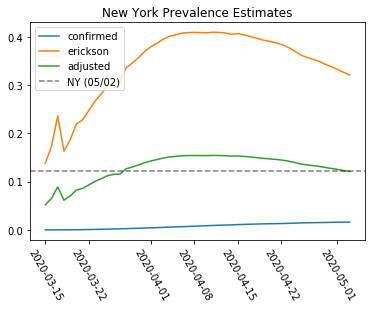

In [88]:
entity = 'New York'
df = states_df
df = df.loc[~before_threshold(df, col='date', thresh=to_datetime('2020-03-15'))]

# df = days_since_trim(df, index_col='entity', days_since_col='date', 
#                      days_since_thresh=to_datetime('2020-03-15'))
dates = df.loc[df['entity'] == entity, 'date']
confs = df.loc[df['entity'] == entity, 'confirmed_prevalence']
erics = df.loc[df['entity'] == entity, 'erickson_prevalence']
adjus = df.loc[df['entity'] == entity, 'adjusted_erickson_prevalence']
plt.plot(dates, confs, label='confirmed')
plt.plot(dates, erics, label='erickson')
plt.plot(dates, adjus, label='adjusted')
ny_seroprevalence = 0.123
plt.axhline(y=ny_seroprevalence, linestyle='--', color='k', alpha=0.5, label='NY (05/02)')
# plt.axvline(x=pd.to_datetime('2020-05-02'), linestyle='--', color='k', alpha=0.5)
plt.xticks(rotation=-60)
plt.legend()
plt.title(f'{entity} Prevalence Estimates')
plt.show()

## Infection Fatality Rate and Herd Immunity

This assumes that the current fatality rates hold. If vulnerable populations are protected and/or therapeutics reduce the fatality rate, these numbers would improve.

At what prevalence will herd immunity be achieved?
- https://academic.oup.com/cid/article/52/7/911/299077 the prevalence required for herd immunity is described in this
  - figure: [(H)erd rate vs R0](https://academic.oup.com/view-large/figure/3862687/cidcir007f02_ht.gif).
  - 40%-80% prevalence for herd immunity, depending on what the R0 of coronavirus.
- https://www.weforum.org/agenda/2020/05/coronavirus-pandemic-last-2-years/
  - herd immunity at 60%-70% prevalence. 
  - [the report](https://www.cidrap.umn.edu/sites/default/files/public/downloads/cidrap-covid19-viewpoint-part1_0.pdf)



In [90]:
df = states_df
df = df.loc[~before_threshold(df, col='date', thresh=to_datetime('2020-03-15')), :].copy()
prevalences = [0.4, 0.6, 0.8]
herds = ['low', 'mid', 'high']
estimates = ['confirmed', 'erickson', 'adjusted']
# dims: entity, date, estimate, herd
# values: herd_prevalence, herd_cases, herd_deaths, herd_deaths_per_million

for prev in prevalences:
    df['herd_cases'] = df['population'] * locals()['herd_prevalence']
    df['confirmed_herd_deaths'] = df['herd_cases'] * df['confirmed_ifr']
    df['erickson_herd_deaths'] = df['herd_cases'] * df['erickson_ifr']
    df['adjusted_erickson_herd_deaths'] = df['herd_cases'] * df['adjusted_erickson_ifr']
    df['confirmed_herd_deaths_per_million'] = df['confirmed_herd_deaths'] / df['population'] * 1000000
    df['erickson_herd_deaths_per_million'] = df['erickson_herd_deaths'] / df['population'] * 1000000
    df['adjusted_erickson_herd_deaths_per_million'] = df['adjusted_erickson_herd_deaths'] / df['population'] * 1000000

dg = df.groupby('entity').last().reset_index().loc[
    :, ['date', 'entity', 'confirmed_herd_deaths', 'erickson_herd_deaths', 'adjusted_erickson_herd_deaths',
        'confirmed_herd_deaths_per_million', 
        'erickson_herd_deaths_per_million', 
        'adjusted_erickson_herd_deaths_per_million', 'population']]

print(f'Total estimated deaths in United States at a herd immunity prevalence level of {herd_prevalence * 100}%')
for col in ['confirmed_herd_deaths', 'erickson_herd_deaths', 'adjusted_erickson_herd_deaths',
           ]:
    print(f'{col}: {df[col].sum().round()} ({(dg[col].sum() / dg["population"].sum() * 1000000):.2f} dpm)')
    
print(f'Estimated deaths by state')
dg

Total estimated deaths in United States at a herd immunity prevalence level of 60.0%
confirmed_herd_deaths: 284693084.0 (26919.02 dpm)
erickson_herd_deaths: 3220098.0 (601.59 dpm)
adjusted_erickson_herd_deaths: 8543299.0 (1596.09 dpm)
Estimated deaths by state


,date,entity,confirmed_herd_deaths,erickson_herd_deaths,adjusted_erickson_herd_deaths,confirmed_herd_deaths_per_million,erickson_herd_deaths_per_million,adjusted_erickson_herd_deaths_per_million,population
0,2020-05-03,Alabama,110440.671845,2083.495146,5527.758304,22524.271845,424.926888,1127.381142,4903185
1,2020-05-03,Alaska,10734.627717,316.633696,840.066532,14673.913043,432.828733,1148.345668,731545
2,2020-05-03,Arizona,182978.857917,2039.241528,5410.348238,25138.888889,280.164970,743.310701,7278717
3,2020-05-03,Arkansas,40108.383095,702.939085,1864.980282,13290.585835,232.930662,617.992514,3017804
4,2020-05-03,California,979404.363753,17741.589805,47070.529816,24787.376902,449.015228,1191.290346,39512223
5,2020-05-03,Colorado,177180.956006,2458.494619,6522.676127,30767.334361,426.915667,1132.657605,5758736
6,2020-05-03,Connecticut,177929.575552,5115.026080,13570.767346,49906.101683,1434.674426,3806.360427,3565287
7,2020-05-03,Delaware,19856.708295,484.037903,1284.209634,20391.705069,497.079275,1318.809932,973764
8,2020-05-03,District of Columbia,21189.353947,693.612679,1840.236228,30023.923445,982.803631,2607.493923,705749
9,2020-05-03,Florida,501135.290387,10019.445285,26582.769820,23332.778979,466.503770,1237.689512,21477737


## Estimates of Infection Fatality Rate by Age

Segmenting the infection fatality rate by age requires knowing:

- the prevalence of infection. We have 3 estimates: confirmed_prevalence, erickson_prevalence, and adjusted_erickson_prevalence.
- population of the age band. We have estimates for census age bands, nyc age bands, 
- deaths by age band. We have data for:
  - NYC
  - Massachusetts
  - 

In [76]:
df = states_df
df = add_erickson_estimates(df)
df = df.loc[~before_threshold(df, col='date', thresh=to_datetime('2020-03-15'))]
dg = df.groupby('entity').last().reset_index()
pop = load_census_state_population_by_age_data(bands='ma')
_, nyc = load_nyc_age_comorbidity_death_data()
ma = load_ma_state_data()
nyc
pop

,entity,ma_age_band,population
0,Alabama,0 to 19,1217278
1,Alabama,20 to 29,665234
2,Alabama,30 to 39,607520
3,Alabama,40 to 49,601274
4,Alabama,50 to 59,651303
...,...,...,...
403,Wyoming,40 to 49,66095
404,Wyoming,50 to 59,71734
405,Wyoming,60 to 69,74038
406,Wyoming,70 to 79,40788


In [77]:
dg.loc[:, ['entity', 'confirmed_prevalence', 'erickson_prevalence', 'adjusted_erickson_prevalence']].head()

,entity,confirmed_prevalence,erickson_prevalence,adjusted_erickson_prevalence
0,Alabama,0.001576,0.083514,0.031477
1,Alaska,0.000503,0.017054,0.006428
2,Arizona,0.001187,0.106510,0.040145
3,Arkansas,0.001137,0.064870,0.024451
4,California,0.001357,0.074909,0.028234


In [79]:
(dg.loc[:, ['entity', 'confirmed_prevalence', 'erickson_prevalence', 'adjusted_erickson_prevalence']]
 .merge(pop, on='entity')
)
# entity, age_band, population, 
# confirmed_prevalence, erickson_prevalence, adjusted_erickson_prevalence, 
# confirmed_ifr, erickson_ifr, adjusted_erickson_ifr
# pop['confirmed_prevalence'] = pop.groupby('entity').transform

,entity,confirmed_prevalence,erickson_prevalence,adjusted_erickson_prevalence,ma_age_band,population
0,Alabama,0.001576,0.083514,0.031477,0 to 19,1217278
1,Alabama,0.001576,0.083514,0.031477,20 to 29,665234
2,Alabama,0.001576,0.083514,0.031477,30 to 39,607520
3,Alabama,0.001576,0.083514,0.031477,40 to 49,601274
4,Alabama,0.001576,0.083514,0.031477,50 to 59,651303
...,...,...,...,...,...,...
403,Wyoming,0.001000,0.056659,0.021356,40 to 49,66095
404,Wyoming,0.001000,0.056659,0.021356,50 to 59,71734
405,Wyoming,0.001000,0.056659,0.021356,60 to 69,74038
406,Wyoming,0.001000,0.056659,0.021356,70 to 79,40788


In [ ]:
df = states_df
# erickson briefing: https://www.youtube.com/watch?v=xfLVxx_lBLU
# erickson population infection rate estimated from cases-per-test
# erickson population cases estimated as infection rate * population
# erickson population chance of death is deaths per population case 
# herd chance of death says, what if the population prevalence is 60% and the death rate remains the same.
#   then herd chance of death is: deaths / (pop prevalence)  deaths per population case

# confirmed cases is a vast underestimate of true cases, since many/most cases are not tested.
#   antibody studies place the population cases at ~16x to 55x (or more) the confirmed cases.
# erickson estimates the true cases using cases-per-test * population. Based on the antibody
#   studies coming out, this seems like an overestimate of the true cases, by ~1-7x?

# Adjust erickson estimate to be closer to seroprevalence results.
# seroprevalence study results
# santa clara county, 2.8% (1.3% to 4.7%), 2002-04-04, tests? cases?
# los angeles county, 4.1% (2.8% to 5.6%), 2020-04-20, tests <not published>, cases 23774 (2020-05-02)
# miami-dade county, 6% (4.4% to 7.9%), 2020-04-24, tests? cases?
# new york state, 12.3%,  2020-05-02 (announced in press briefing).
# new york state: 2020-05-02, tests 959071 cases 312977
ny_seroprevalence = 0.123
seroprevalence_adjustment = ny_seroprevalence / (312977 / 959071)

df['confirmed_prevalence'] = df['cases'] / df['population']
df['erickson_cases'] = (df['cases_per_test'] * df['population']).round()
df['erickson_prevalence'] = df['cases_per_test']
df['adj_erickson_prevalence'] = df['erickson_prevalence'] * seroprevalence_adjustment
df['erickson_deaths_per_case'] = df['deaths'] / df['erickson_cases']
df['erickson_cases_per_confirmed_case'] = df['erickson_cases'] / df['cases']
df['herd_cases'] = df['population'] * 0.6
df['herd_dpm'] = df['deaths_per_case'] * 1e6 * 0.6
df['herd_erickson_dpm'] = df['erickson_deaths_per_case'] * 1e6 * 0.6
# df['herd_deaths']
# df['herd_chance_of_death'] = df['erickson_chance_of_death'] * (0.6 / df['cases_per_test']) 
df['erickson_cases'] = df['erickson_cases'].apply(lambda x: x if pd.isnull(x) else int(x))

In [ ]:
(df
 .loc[df['entity'].isin(states), [
     'entity', 'date', 
     'deaths', 
     'tests', 
     'cases',
     'population', 
 ]]
 .groupby('entity').last()
)


In [ ]:
(df
 .loc[df['entity'].isin(states), [
     'entity', 'date', 
     'deaths_per_case',
 ]]
 .groupby('entity').last()
)


In [ ]:
(df
 .loc[df['entity'].isin(states), [
     'entity', 'date', 
     'cases_per_test',
     'erickson_cases',
     'erickson_deaths_per_case',
 ]]
 .groupby('entity').last()
)



In [ ]:
(df
 .loc[df['entity'].isin(states), [
     'entity', 'date', 
     'erickson_cases_per_confirmed_case',
 ]]
 .groupby('entity').last()
)


In [ ]:
(df
 .loc[df['entity'].isin(states), [
     'entity', 'date', 
     'herd_dpm',
     'herd_erickson_dpm',
 ]]
 .groupby('entity').last().sort_values(by='herd_erickson_dpm')
)

In [ ]:
df['nys_multiple'] = (0.144 * df['population']) / df['cases']
df.loc[df['entity'] == 'New York', :].tail()

In [ ]:
seroprevalence = pd.Series({
     'California': 0.03, 
     'Florida': 0.06,
     'New York': 0.14
    }, name='seroprevalence')

(df
 .loc[df['entity'].isin(states), [
     'entity', 'date', 
     'cases_per_test',
     'erickson_cases',
     'erickson_deaths_per_case',
     'cases_per_capita',
     'erickson_cases_per_capita',
     'erickson_cases_per_confirmed_case',
 ]]
 .groupby('entity').last()
).join(seroprevalence, how='left')



Feedback on my email.

> Thanks Todd this is great! Very accessible writing. 

> Can you add an analysis and conclusion for the old and sick?

> Also re: your conclusion for society (and other "open it up!" advocates)...
> 
> - About 1/3 of Americans are 60 or older
> - About the same percentage of adults have hypertension 
> - 10.5% are diabetic
> - 40% of adults are obese

> These are not additive, of course, but we are talking about simultaneously isolating and protecting between 1/3 and greater than 50% of people, while everyone else gets a disease. That is a fantasy. If we are getting to 60% antibodies, a lot of people over 60 and with comorbidities are getting it too. 

> Also, the current economic damage is not being done by a hard lockdown. Most places have a soft lockdown or less (many categories of stores open, huge categories of workers considered essential, freedom to travel and use public streets and, in most cases, open parks).  There is guidance to stay at home and many people are choosing to limit travel and activity because they have a legitimate fear for someone over 60 or with comorbidities. So, what reduction in activity is reasonable for a disease with a death rate for those over 60 and with comorbidities of, say 1%-5%? Closed stadiums, concert venues and movie theaters? Limited international travel? Increased spacing in bars and restaurants? Avoiding amusement parks and cruises? Pretty quickly it adds up to, what, 10% of the economy? 20%? Shutting that fraction of the economy for months and months is devastating and inevitable if it the disease is at epidemic levels.

## New York City: Age and Comorbidities

Explore how the case fatality rate differs for younger cohorts vs the entire population of cases. Explore how many of the people dying have comorbidities.

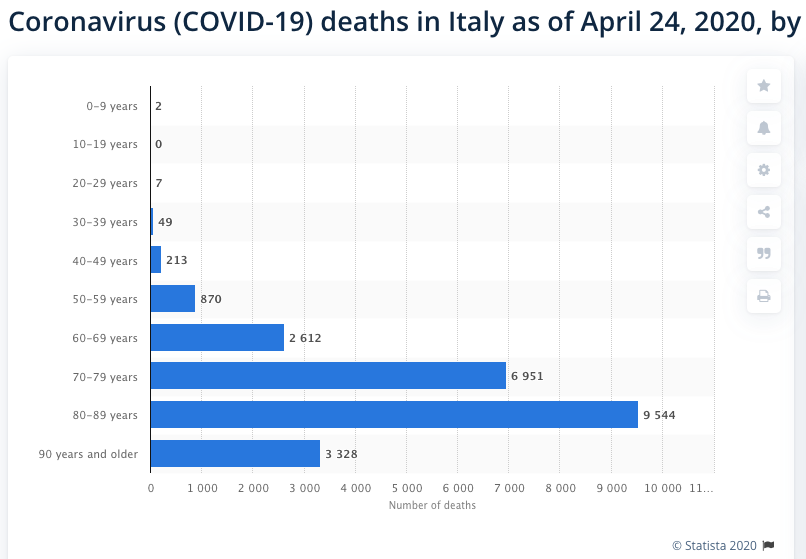

In [ ]:
deaths_df, df = load_nyc_age_comorbidity_death_data()
print(deaths_df.pivot(index='age_band', columns='comorbidity'))
# print(df)
deaths_df.groupby('age_band').sum()['deaths']

# nyc deaths-per-case
print('NYC deaths_per_case')
print(df['deaths'].sum() / df['cases'].sum())
# nyc deaths-per-case under 65
print('NYC deaths_per_case under 65')
u65 = df.loc[df['age_band'].isin(['0-17', '18-44', '45-64'])]
u65_deaths_per_case = u65['deaths'].sum() / u65['cases'].sum()
print(u65_deaths_per_case)
# nyc deaths-per-case under 45
print('NYC deaths_per_case under 45')
u45 = df.loc[df['age_band'].isin(['0-17', '18-44'])]
u45_deaths_per_case = u45['deaths'].sum() / u45['cases'].sum()
print(u45_deaths_per_case)
# among people who are dying, what fraction of them have comorbidities?
comorb = deaths_df.groupby('comorbidity').sum()
print('Percent of NYC deaths with comorbidity')
high_comorb_pct = (comorb.loc['yes', 'deaths'] + comorb.loc['unknown', 'deaths']) / comorb['deaths'].sum()
low_comorb_pct = comorb.loc['yes', 'deaths'] / comorb['deaths'].sum()
no_unk_comorb_pct = comorb.loc['yes', 'deaths'] / (comorb.loc['yes', 'deaths'] + comorb.loc['no', 'deaths'])
print(low_comorb_pct, no_unk_comorb_pct, high_comorb_pct)


## Infection Fatality Rate by Age

For states that have cases and deaths by age.
- Estimate prevalence 3 ways: confirmed cases, erickson estimate (cases/tests), and seroprevalence-adjusted erickson estimate from the NY seroprevalence study.
- Apply prevalence to to find infections by age per state.
- Calculate IFR using {confirmed-, erickson- and adjusted-erickson- prevalence} for age groups.

The file `data\cc-est2018-alldata.csv` contains 2018 estimates of county population by age band. This is used to estimate the infections (i.e. cases) by age band, to break down infection fatality rate estimates by age band and state.

In [ ]:
pop = load_census_state_population_by_age_data(bands='nyc')
pop

In [ ]:
state = 'Vermont'
ages = df.loc[(df['entity'] == state), 'nyc_age_band']
age_ticks = np.arange(1, len(ages) + 1)
populations = df.loc[df['entity'] == state, 'population']
plt.bar(age_ticks, populations)
plt.xticks(ticks=age_ticks, labels=list(ages), rotation=-60)
plt.show()
df.head(10)

In [ ]:
df = states_df

In [ ]:
states = ['New York', 'Massachusetts', 'California', 'Florida']
(df
 .loc[df['entity'].isin(states), [
     'entity', 'date', 
     'confirmed_prevalence', 
     'erickson_prevalence', 
     'adj_erickson_prevalence',
     'population', 
 ]]
 .groupby('entity').last()
)

KeyError: 'adj_erickson_prevalence'

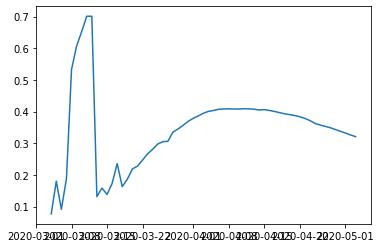

In [16]:
piv = df.pivot(index='date', columns='entity', values='erickson_prevalence')
plt.plot(piv.index, piv['New York'])
piv = df.pivot(index='date', columns='entity', values='adj_erickson_prevalence')
plt.plot(piv.index, piv['New York'])
plt.axhline(y=ny_seroprevalence, linestyle='--', color='k')